In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# Load training data
train_data_import = pd.read_csv("../TrainingData/neodata/fault_all_250.csv")
train_data_import.sample(frac=1).head()

,Pdis,Psuc,T0,Tc,Tdis,Tret,Tsuc,Tsh,Tsup,CondFan,CprPower,Density,Tamb,Tset,target
28600,8.227432,2.161615,-8.091958,32.315639,39.369327,6.118103,-1.202436,6.889522,0.000042,59.062654,2502.869001,4.887764,30,0,6
63535,8.293045,3.913924,8.286423,32.596899,39.070698,19.355556,14.466959,6.180537,12.000059,62.187767,826.393833,8.625123,10,12,14
81385,8.000800,3.410285,4.283283,31.330976,38.657853,12.705848,9.638881,5.355598,7.000049,48.121958,786.943884,7.575575,10,7,18
59197,8.293049,3.913921,8.286401,32.596915,37.070756,21.355564,14.466955,6.180553,12.000050,62.187945,826.399913,8.625116,10,12,13
76314,9.918235,3.828648,7.637462,39.083062,67.470882,26.438669,22.637759,15.000288,13.505036,100.000000,4282.343103,8.311075,30,12,16


----
# Linear Discriminant Analysis of data
----

In [3]:
# Config

train_data = train_data_import.copy()

sigma = 0.001

ignore_features = []
ignore_targets = []

# ignore_features = ["Tamb"]
# ignore_targets = [17,18,19]

features = train_data_import.columns.to_list()
targets = train_data_import['target'].unique().tolist()

# Remove unwanted
for i in ignore_targets:
    targets.remove(i)
    
for i in ignore_features:
    train_data.pop(i)

In [4]:
# Temporarily remove target column
target = train_data.pop('target')

import standardization as sd

stand = sd.standardization(train_data_import,'target')
train_data = stand.transform(train_data_import)

# Add gaussian noise
train_data += np.random.randn(train_data.shape[0],train_data.shape[1])*sigma

# Reapply taget column
train_data = train_data.assign(target=target)

In [5]:
train_data.head()

,Pdis,Psuc,T0,Tc,Tdis,Tret,Tsuc,Tsh,Tsup,CondFan,CprPower,Density,Tamb,Tset,target
0,-1.036030,-0.473391,-0.510760,-1.093726,-0.364366,-0.914504,-0.953563,-1.101603,-0.689579,-1.039388,-0.859283,-0.461765,-1.225987,-1.286489,0
1,-1.036587,-0.473840,-0.510231,-1.094766,-0.364267,-0.915004,-0.956450,-1.101298,-0.691276,-1.037448,-0.858460,-0.459899,-1.224507,-1.286400,0
2,-1.037440,-0.475433,-0.509403,-1.092925,-0.363650,-0.915134,-0.954978,-1.100090,-0.691060,-1.040442,-0.860043,-0.460405,-1.222649,-1.285221,0
3,-1.037234,-0.473606,-0.508529,-1.092742,-0.364732,-0.914756,-0.954672,-1.100134,-0.690792,-1.039499,-0.858780,-0.461752,-1.225033,-1.286728,0
4,-1.034828,-0.475089,-0.510658,-1.094340,-0.364804,-0.915620,-0.955198,-1.101146,-0.690647,-1.040976,-0.857877,-0.460607,-1.223199,-1.285819,0


----
# Dimensionality reduction using LDA

Preserving 99.28% of variance


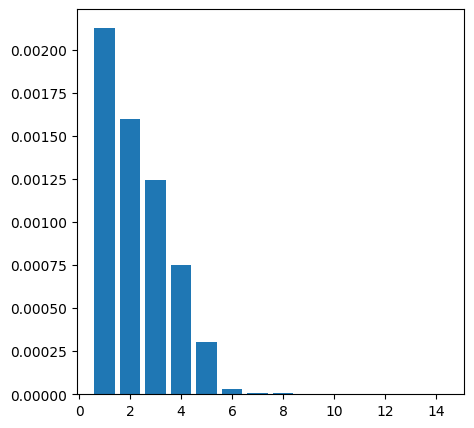

In [6]:
from lda import LDA_reducer as reducer
lda = reducer(train_data,5,'target')

0.7674603174603175


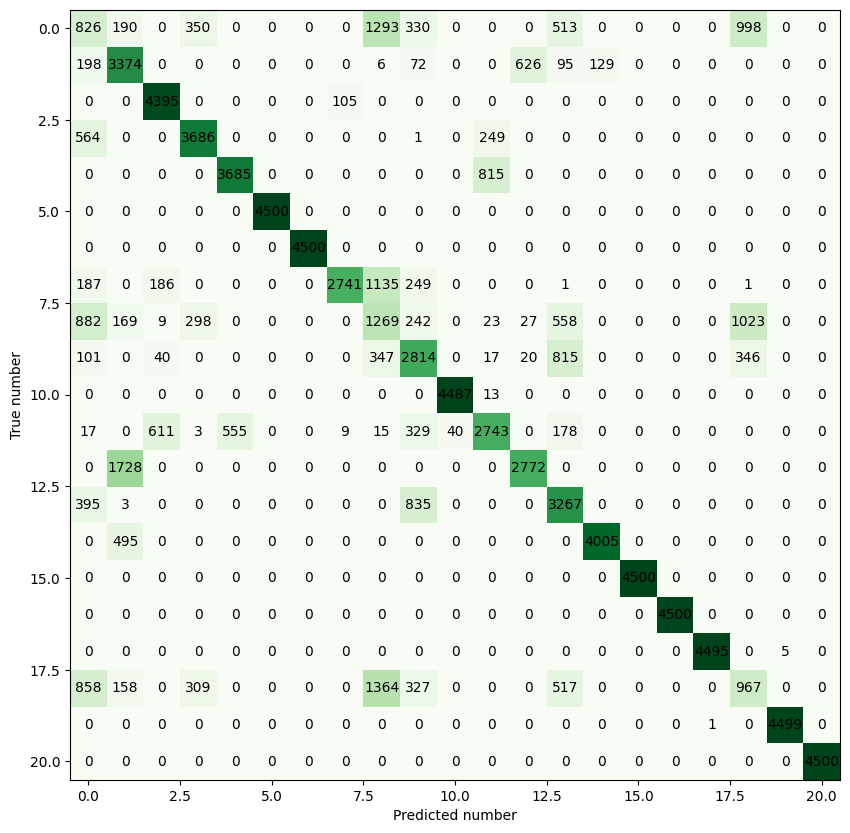

In [12]:
train_z = lda.transform(train_data)

dimReduced = train_z.drop('target',axis=1)

from sklearn.naive_bayes import GaussianNB
from sklearn import metrics as me

clfGauss = GaussianNB()
clfGauss.fit(dimReduced,target)
prediction_Gauss=clfGauss.predict(dimReduced)
conf_matrix = me.confusion_matrix(target,prediction_Gauss)

fig , axs = plt.subplots(figsize=(10,10))
axs.imshow(conf_matrix,cmap="Greens")
axs.set_xlabel("Predicted number")
axs.set_ylabel("True number")

width, height = conf_matrix.shape

for x in range(width):
    for y in range(height):
        axs.annotate(str(int(conf_matrix[x][y])), xy=(y, x), 
        horizontalalignment='center',
        verticalalignment='center')

target_np=np.array(target)
correctCount =0
# Calculate accuracy
for n in range(len(prediction_Gauss)):
    if(target_np[n]==prediction_Gauss[n]):
        correctCount = correctCount + 1     #Clumsy syntax --> Avoid mistakes

print(correctCount/len(prediction_Gauss))


In [8]:
from scipy.stats import multivariate_normal as mvn
from numpy import real

# Run classification
correct = [0 for x in range(len(targets))]
incorrects = []

test_z = train_z.sample(frac=0.05)

conf_matrix = np.zeros((len(targets),len(targets)))

for sample in test_z.iterrows():
    # Find the argument with the highest 
    if sample[1]['target'] in targets:
        arg = np.argmax([mvn.pdf(real(sample[1].drop('target')),real(c[n]["mean"]),real(c[n]["cov"])) for n in targets])
        guess = targets[arg]
        
        conf_matrix[targets.index(int(sample[1]['target'])),int(arg)] += 1

NameError: name 'c' is not defined

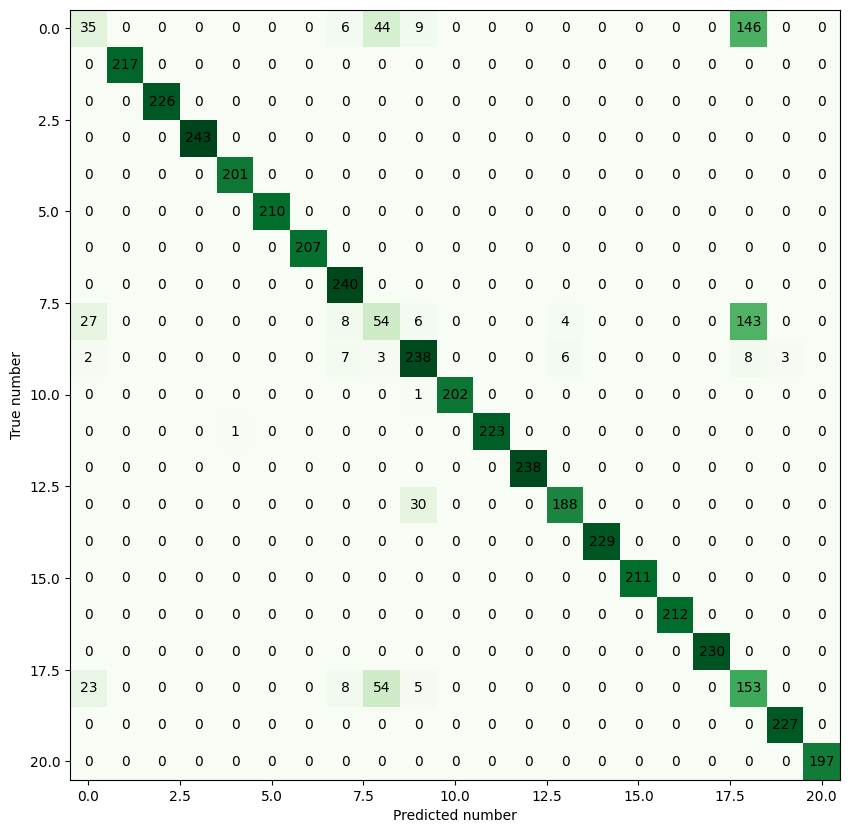

In [ ]:
fig , axs = plt.subplots(figsize=(10,10))
axs.imshow(conf_matrix,cmap="Greens")
axs.set_xlabel("Predicted number")
axs.set_ylabel("True number")

width, height = conf_matrix.shape

for x in range(width):
    for y in range(height):
        axs.annotate(str(int(conf_matrix[x][y])), xy=(y, x), 
            horizontalalignment='center',
            verticalalignment='center')

In [ ]:
# Print results
for i in targets:
    id = targets.index(i)
    corr = correct[targets.index(i)]
    total = len(test_z[test_z['target'] == i])
    print(f"{i} : \t{int(conf_matrix[id,id])}/{int(sum(conf_matrix[id,:]))}\t {round(conf_matrix[id,id]/sum(conf_matrix[id,:])*100,3)}%")
    
tot_corr = int(sum([conf_matrix[targets.index(x),targets.index(x)] for x in targets]))
tot = int(len(test_z))
    
print(f"TOT : \t{tot_corr}/{tot}\t {round((tot_corr/tot)*100,3)}%")

0 : 	35/240	 14.583%
1 : 	217/217	 100.0%
2 : 	226/226	 100.0%
3 : 	243/243	 100.0%
4 : 	201/201	 100.0%
5 : 	210/210	 100.0%
6 : 	207/207	 100.0%
7 : 	240/240	 100.0%
8 : 	54/242	 22.314%
9 : 	238/267	 89.139%
10 : 	202/203	 99.507%
11 : 	223/224	 99.554%
12 : 	238/238	 100.0%
13 : 	188/218	 86.239%
14 : 	229/229	 100.0%
15 : 	211/211	 100.0%
16 : 	212/212	 100.0%
17 : 	230/230	 100.0%
18 : 	153/243	 62.963%
19 : 	227/227	 100.0%
20 : 	197/197	 100.0%
TOT : 	4181/4725	 88.487%
